In [1]:
import itertools

import h5py
import yaml
import scipy
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import lab.metrics

idx = pd.IndexSlice

# Distribution of Packet Sizes

In [2]:
def load_packet_sizes(dataset="../results/trace-dataset.hdf"):
    with h5py.File(dataset, mode="r") as h5file:
        return np.asarray(h5file["sizes"], dtype="object")

packet_sizes = load_packet_sizes()
packet_sizes

array([array([ 140, -156,  124, ..., -124, -220,  124], dtype=int32),
       array([ 124, -140, 1452, ..., -268, -108,  124], dtype=int32),
       array([ 124, -140, 1452, ..., -572,  124, -124], dtype=int32), ...,
       array([  124,  -140,   124, ..., -1480,   124, -1480], dtype=int32),
       array([  124,  -140,   124,   124,  -124,   124,   636,  -124,   124,
         636,  -124, -1480, -1480,  -892,   124,   124,   220,   220,
         476,  -124, -1480, -1480,  -892,   124,   124,   124,   220,
        -348,  -204,   124,   156, -1480, -1480, -1276,   124,   124,
         124,   124,   124,   300,  -348,   124,  -140,   124,  -140,
         124,   124,   124,  -124,  -124,   124,   428,  -124, -1480,
       -1480, -1480, -1480, -1480,  -524,   124,   124,   124,  -124,
        -124,  -124,   124,   124,   124,   636,   636,   636,   124,
        -156,   124,  -124,  -124,  -124, -1480,  -892,   124,   124,
       -1480,  -892,   124, -1480,   124,  -892,   124,   124,   140,
  

Fraction of outgoing packets with less than 130 bytes 0.7
Fraction of outgoing packets with less than 175 bytes 0.78
Fraction of incoming packets with less than 130 bytes 0.092
Fraction of incoming packets with less than 175 bytes 0.13


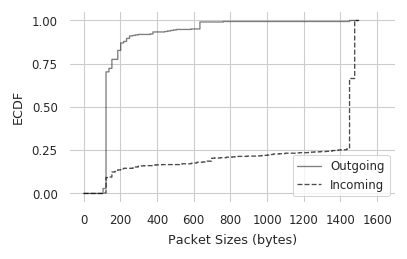

In [3]:
def plot_packet_size_distribution(sizes):
    plot_sizes = np.concatenate(sizes)[:1000]
    assert not np.any(plot_sizes == 0)
    
    figure, axes = plt.subplots(figsize=(3.5, 2.1), dpi=120)

    x = np.arange(0, 1501, 2)

    # Plot the outgoing packet-sizes (client->server)
    outgoing_ecdf = ECDF(plot_sizes[plot_sizes > 0])
    axes.step(x, outgoing_ecdf(x), label="Outgoing", linestyle="-", c='k', alpha=.5, marker="None")

    print(f"Fraction of outgoing packets with less than 130 bytes {outgoing_ecdf(129):.2g}")
    print(f"Fraction of outgoing packets with less than 175 bytes {outgoing_ecdf(174):.2g}")

    # Plot the incoming packet-sizes (server->client)
    incoming_ecdf = ECDF(np.abs(plot_sizes[plot_sizes < 0]))
    axes.step(x, incoming_ecdf(x), label="Incoming", linestyle="--", c='k', alpha=.7, marker="None")

    print(f"Fraction of incoming packets with less than 130 bytes {incoming_ecdf(129):.2g}")
    print(f"Fraction of incoming packets with less than 175 bytes {incoming_ecdf(174):.2g}")

    axes.set_xlim(right=1700)
    axes.set_xlabel("Packet Sizes (bytes)")
    axes.set_xticks(np.arange(0, 1601, 200))
    axes.set_ylabel("ECDF")
    axes.legend()
    
    return figure

with plt.style.context([
    "mpl-style/pets.mplstyle", "mpl-style/white-grid.mplstyle", 
    "mpl-style/line-plots.mplstyle"
]):
    figure = plot_packet_size_distribution(packet_sizes)
    figure.savefig("../results/plots/packet-size-ecdf.pgf", bbox_inches="tight", dpi=150)

# Packet-Size Threshold Performance

In [4]:
# Load the sizes from the configuration file
with open("../config/config.yaml", mode="r") as configfile:
    config = yaml.safe_load(configfile)
display(config)

{'classifiers': ['dfnet', 'varcnn-time', 'varcnn-sizes', 'p1fp', 'kfp'],
 'n_gpus': {'dfnet': 2,
  'varcnn-time': 2,
  'varcnn-sizes': 2,
  'p1fp': 1,
  'kfp': 0},
 'n_threads': {'dfnet': 2,
  'varcnn-time': 2,
  'varcnn-sizes': 2,
  'p1fp': 2,
  'kfp': 4},
 'thresholds': [1, 130, 175],
 'n_repetitions': 10,
 'script_path': 'scripts/docker-run-experiment',
 'min_packet_size': 175}

In [5]:
def load_results(classifiers: list, repetitions: int, min_sizes: list):
    combinations = list(itertools.product(classifiers, min_sizes, range(repetitions)))
    return pd.concat([
        pd.read_csv(f"../results/{classifier}/predictions-{size}-{rep:02d}.csv")#, header = None, names=["run", "y_true"] + list(range(-1, 100)))
        for (classifier, size, rep) in combinations
    ], keys=combinations, names=["classifier", "min_size", "run", "sample"])


# data = load_results(["kfp"], config["n_repetitions"], config["thresholds"])
data = load_results(config["classifiers"], config["n_repetitions"], config["thresholds"])
display(data)

y_true        -1             0             1  \
classifier min_size run sample                                                 
dfnet      1        0   0         -1.0  0.069673  2.771017e-06  3.074019e-09   
                        1         -1.0  0.994079  1.671553e-11  3.426360e-13   
                        2         51.0  0.000133  5.160465e-11  1.689096e-12   
                        3         -1.0  1.000000  9.330400e-12  1.781738e-11   
                        4         -1.0  1.000000  6.757410e-17  4.640288e-19   
...                                ...       ...           ...           ...   
kfp        175      9   5849      -1.0  1.000000  0.000000e+00  0.000000e+00   
                        5850      42.0  0.000000  0.000000e+00  0.000000e+00   
                        5851      -1.0  1.000000  0.000000e+00  0.000000e+00   
                        5852      -1.0  1.000000  0.000000e+00  0.000000e+00   
                        5853      60.0  0.000000  0.000000e+00  0.000000e+00   

                                           2             3             4  \
classifier min_size run sample                                             
dfnet      1        0   0       9.301799e-01  4.748701e-07  1.488906e-08   
                        1       2.315033e-13  4.814340e-11  3.719869e-09   
                        2       5.650325e-12  4.609020e-09  4.357676e-14   
                        3       2.386034e-15  1.848699e-16  6.165791e-13   
                        4       2.414027e-26  1.017121e-21  7.670983e-23   
...                                      ...           ...           ...   
kfp        175      9   5849    0.000000e+00  0.000000e+00  0.000000e+00   
                        5850    0.000000e+00  0.000000e+00  0.000000e+00   
                        5851    0.000000e+00  0.000000e+00  0.000000e+00   
                        5852    0.000000e+00  0.000000e+00  0.000000e+00   
                        5853    0.000000e+00  0.000000e+00  0.000000e+00   

                                           5             6             7  ...  \
classifier min_size run sample                                            ...   
dfnet      1        0   0       4.991435e-05  2.171806e-08  1.419927e-08  ...   
                        1       5.753861e-15  7.320879e-09  5.495243e-08  ...   
                        2       4.686558e-14  3.165795e-14  8.968993e-13  ...   
                        3       2.387236e-15  3.324990e-13  2.408385e-14  ...   
                        4       1.114839e-25  3.322915e-25  2.279977e-15  ...   
...                                      ...           ...           ...  ...   
kfp        175      9   5849    0.000000e+00  0.000000e+00  0.000000e+00  ...   
                        5850    0.000000e+00  0.000000e+00  0.000000e+00  ...   
                        5851    0.000000e+00  0.000000e+00  0.000000e+00  ...   
                        5852    0.000000e+00  0.000000e+00  0.000000e+00  ...   
                        5853    0.000000e+00  0.000000e+00  0.000000e+00  ...   

                                          90            91            92  \
classifier min_size run sample                                             
dfnet      1        0   0       7.005877e-06  3.825294e-08  2.848334e-08   
                        1       5.138659e-11  8.993923e-04  7.735379e-10   
                        2       1.194585e-11  6.128323e-14  2.319384e-12   
                        3       6.852496e-17  1.563061e-18  3.529360e-14   
                        4       2.865838e-29  3.537654e-19  3.525401e-23   
...                                      ...           ...           ...   
kfp        175      9   5849    0.000000e+00  0.000000e+00  0.000000e+00   
                        5850    0.000000e+00  0.000000e+00  0.000000e+00   
                        5851    0.000000e+00  0.000000e+00  0.000000e+00   
                        5852    0.000000e+00  0.000000e+00  0.000000e+00   
                        5853    0.00

In [6]:
def score(frame, ratio=1):
    classes = np.arange(-1, 100)
    classes_cols = [str(class_) for class_ in classes]
    probabilities = frame.loc[:, classes_cols].values
    
    y_true = frame["y_true"]
    y_pred = classes[np.argmax(probabilities, axis=1)]
    
    return pd.Series({
        "precision": lab.metrics.rprecision_score(y_true, y_pred, ratio=ratio, zero_division=1),
        "recall": lab.metrics.recall_score(y_true, y_pred)
    })

In [7]:
plot_data = (data
             .groupby(["classifier", "min_size", "run"])
             .apply(score, ratio=20)
             .rename_axis("metric", axis=1)
             .stack()
             .rename("score")
             .transform(lambda x: x*100)
             .unstack("min_size")
             .reorder_levels([0, 2, 1])
             .rename({"dfnet": "DF", "varcnn-sizes": "Var-CNN$_S$", "varcnn-time": "Var-CNN$_T$", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
             .rename({"precision": "Precision (%)", "recall": "Recall (%)"}, axis=0 )
             .rename({1: "None"}, axis=1)
             .sort_index())

# TODO: Why do some runs result in a precision of 0?
plot_data

min_size                            None        130        175
classifier  metric        run                                 
$k$-FP      Precision (%) 0    91.949606  93.344080  95.384117
                          1    90.883212  93.410808  94.244614
                          2    91.360178  95.060719  96.245424
                          3    90.964321  92.083920  93.546351
                          4    92.753425  95.878843  90.604302
...                                  ...        ...        ...
Var-CNN$_T$ Recall (%)    5     2.500000  30.300000  14.900000
                          6    61.000000  14.100000  25.900000
                          7     5.500000  35.300000  28.800000
                          8     4.600000  12.200000  16.600000
                          9    19.100000   7.000000  34.700000

[100 rows x 3 columns]

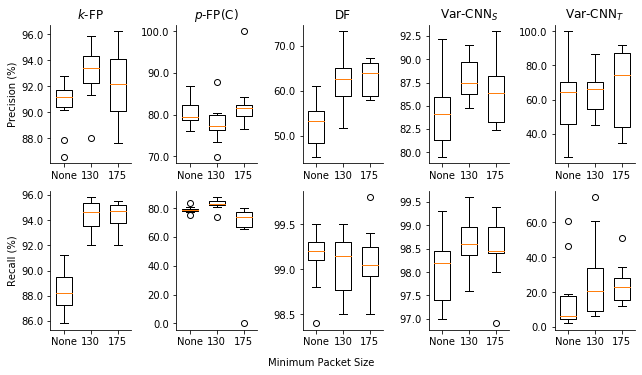

In [8]:
def plot(axes, classifier, metric, frame, label: bool = False, title: bool = False):
    axes.boxplot(frame.xs([classifier, metric]).values, widths=.6, labels=frame.columns)
    
    visible = True
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(visible)
    axes.spines['bottom'].set_visible(visible)
    axes.grid(False, which="major", axis="x")
    if label:
        axes.set_ylabel(metric)
    if title:
        axes.set_title(classifier)
        

figure, axes = plt.subplots(2, 5, figsize=(9, 5)) 
    
results = {}
for i, (classifier, group) in enumerate(plot_data.groupby("classifier")):
    plot(axes[0][i], classifier, "Precision (%)", plot_data, label=(i==0), title=True)
    plot(axes[1][i], classifier, "Recall (%)", plot_data, label=(i==0))
    
    for position in [0, 1]:
        axes[position][i].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
        
    results[classifier] = (figure, axes[0][i], axes[1][i])
    
figure.tight_layout(pad=1)
figure.text(0.5, -0.025, 'Minimum Packet Size', ha='center')

def set_ylim(axes, bottom=None, top=100):
    if bottom is None:
        bottom = axes.get_ylim()[0]
    margin = (top - bottom) * 0.02
    axes.set_ylim(bottom - margin, top + margin)

# set_ylim(results["DF"][1])
# set_ylim(results["Var-CNN$_S$"][1], bottom=97)
# set_ylim(results["Var-CNN$_T$"][1])
# set_ylim(results["$k$-FP"][1], bottom=97)
# # TODO: Document the outliers
# set_ylim(results["$p$-FP(C)"][1], bottom=94)
#  
# set_ylim(results["DF"][2], bottom=97)
# set_ylim(results["Var-CNN$_S$"][2], bottom=96)
# set_ylim(results["Var-CNN$_T$"][2], bottom=0)
# set_ylim(results["$k$-FP"][2])
# # TODO: Document the outliers
# set_ylim(results["$p$-FP(C)"][2], bottom=70)

figure.savefig("../results/plots/score-vs-min-packet-size.pdf", dpi=150, bbox_inches="tight")

In [9]:
table_data = plot_data.stack().unstack("classifier").reorder_levels([0, 2, 1]).sort_index().iloc[:, [2, 0, 3, 4, 1]]
table_data

classifier                         DF     $k$-FP  Var-CNN$_S$  Var-CNN$_T$  \
metric        min_size run                                                   
Precision (%) None     0    53.517088  91.949606    92.225898    54.837981   
                       1    53.283893  90.883212    80.983344    63.890257   
                       2    45.940210  91.360178    87.712449    39.205947   
                       3    49.401400  90.964321    82.955259   100.000000   
                       4    48.073729  92.753425    85.380643    42.604429   
                       5    55.683181  87.841941    82.426352    85.858229   
                       6    54.867274  90.198361    86.071483    64.858791   
                       7    61.047650  91.481732    85.641163    71.800099   
                       8    56.994093  91.830627    79.471447    67.053863   
                       9    45.300865  86.537195    80.233046    26.548516   
              130      0    58.652565  93.344080    91.506500    79.274128   
                       1    73.329839  93.410808    84.736702    70.463016   
                       2    65.257185  95.060719    86.339714    56.408851   
                       3    51.757413  92.083920    86.930482    86.907396   
                       4    63.491982  95.878843    89.903579    53.912320   
                       5    59.965192  94.560668    85.204943    50.828180   
                       6    73.070004  91.322724    87.966911    45.382534   
                       7    64.997481  92.643507    89.191293    67.375048   
                       8    61.915206  88.010976    86.296539    69.096730   
                       9    58.693398  93.704991    89.814730    64.765151   
              175      0    67.454264  95.384117    88.517004    34.686189   
                       1    58.368636  94.244614    82.696830    72.917838   
                       2    66.315672  96.245424    93.034635    87.640924   
                       3    64.881821  93.546351    83.216965    87.771423   
                       4    58.218062  90.604302    86.651209    76.071964   
                       5    63.324750  91.640853    83.385668    51.399454   
                       6    57.916342  89.894793    86.083546    91.973920   
                       7    65.938358  92.730040    88.605676    41.956224   
                       8    67.427144  87.617973    82.402676    37.859832   
                       9    60.534879  88.771490    87.172251    85.745834   
Recall (%)    None     0    99.200000  85.800000    97.700000     2.000000   
                       1    99.100000  87.200000    98.200000     5.100000   
                       2    99.200000  89.200000    97.000000    15.000000   
                       3    99.400000  91.200000    98.200000     6.900000   
                       4    99.500000  89.600000    98.600000    46.600000   
                       5    98.400000  87.000000    98.500000     2.500000   
                       6    99.300000  91.000000    99.300000    61.000000   
                       7    98.800000  88.500000    98.300000     5.500000   
                       8    99.100000  88.000000    97.300000     4.600000   
                       9    99.300000  87.400000    97.000000    19.100000   
              130      0    99.300000  93.800000    97.600000     6.300000   
                       1    98.500000  93.400000    98.300000    27.000000   
                       2    99.000000  95.100000    98.900000    60.700000   
                       3    99.400000  95.800000    98.600000     8.200000   
                       4    99.000000  95.800000    99.000000    74.400000   
                       5    99.300000  94.800000    99.600000    30.300000   
                       6    99.500000  95.400000    99.400000    14.100000   
                       7    98.700000  93.400000    98.600000    35.300000   
                       8    99.300000  94.500000    98.600000    12.200000   
                      

In [10]:
def to_latex_table(data, float_fmt=".1f"):
    medians = data.groupby(level=[0, 1]).median()
    iq_range = data.groupby(level=[0, 1]).quantile([0.25, 0.75])
    iq_range.index.names = iq_range.index.names[:2] + ["IQR"]
    
    columns = data.columns.values
    metrics = data.index.unique(level=0).values
    factors = data.index.unique(level=1).values
    
    result_lines = []
    result_lines.append(r"\begin{tabular}{l%s}" % ("r" * len(columns)))
    result_lines.append(r"\toprule")
    result_lines.append(r" & %s \\" % " & ".join(columns))
    result_lines.append(r"\midrule")
    
    for metric in metrics:
        result_lines.append(r"metric = %s \\" % metric.replace("%", r"\%"))
        
        for factor in factors:
            fmt_string = f"{{median:{float_fmt}}} ({{lq:{float_fmt}}}--{{uq:{float_fmt}}})"
            values = [fmt_string.format(median=median, lq=lq, uq=uq) for (median, lq, uq) in 
                      zip(medians.xs([metric, factor]).values,
                          iq_range.xs([metric, factor, 0.25]),
                          iq_range.xs([metric, factor, 0.75]))]
            values = " & ".join(values)
            result_lines.append(r"\quad %s & %s \\" % (factor, values))
    result_lines.append(r"\bottomrule")
    result_lines.append(r"\end{tabular}")
    
    return "\n".join(result_lines)

print(to_latex_table(table_data.rename({"Precision (%)": "$\pi_{20}$ (%)"})))

\begin{tabular}{lrrrrr}
\toprule
 & DF & $k$-FP & Var-CNN$_S$ & Var-CNN$_T$ & $p$-FP(C) \\
\midrule
metric = $\pi_{20}$ (\%) \\
\quad None & 53.4 (48.4--55.5) & 91.2 (90.4--91.7) & 84.2 (81.3--86.0) & 64.4 (45.7--70.6) & 79.5 (78.8--82.3) \\
\quad 130 & 62.7 (59.0--65.2) & 93.4 (92.2--94.3) & 87.4 (86.3--89.7) & 66.1 (54.5--70.1) & 77.3 (76.2--79.8) \\
\quad 175 & 64.1 (58.9--66.2) & 92.2 (90.1--94.1) & 86.4 (83.3--88.2) & 74.5 (44.3--87.2) & 81.5 (79.6--82.3) \\
metric = Recall (\%) \\
\quad None & 99.2 (99.1--99.3) & 88.2 (87.2--89.5) & 98.2 (97.4--98.5) & 6.2 (4.7--18.1) & 78.5 (77.8--79.6) \\
\quad 130 & 99.2 (98.8--99.3) & 94.7 (93.5--95.3) & 98.6 (98.4--99.0) & 20.5 (9.2--34.0) & 83.0 (82.1--84.8) \\
\quad 175 & 99.0 (98.9--99.2) & 94.7 (93.8--95.2) & 98.5 (98.4--99.0) & 23.0 (15.3--28.2) & 74.0 (66.7--77.1) \\
\bottomrule
\end{tabular}


In [11]:
import lab.analytics
table_data.groupby("metric").apply(lab.analytics.median_difference, level="min_size").applymap("{0:.2g}".format)

classifier                    DF $k$-FP Var-CNN$_S$ Var-CNN$_T$ $p$-FP(C)
metric                                                                   
Precision (%) (None - 130)  -9.3   -2.2        -3.3        -1.7       2.2
              (None - 175)   -11     -1        -2.2         -10        -2
              (130 - 175)   -1.4    1.2         1.1        -8.4      -4.2
Recall (%)    (None - 130)  0.05   -6.4        -0.4         -14      -4.5
              (None - 175)  0.15   -6.4       -0.25         -17       4.5
              (130 - 175)    0.1  -0.05        0.15        -2.5         9